##TCINet on Nonlinear Synthetic Data
Author: Sahara Ali

In [ ]:
from numpy.random import seed
seed(1)

###Readme:

- Covariate: 2 ->
       'S1 (t)', 'S2 (t)'
- Treatment ->
       'S3 (t)'
- Output Predictand:
       'S4 (t+1)'
- No. of records: 100000
- Look-up window: 1 timestep
- Causal Graph

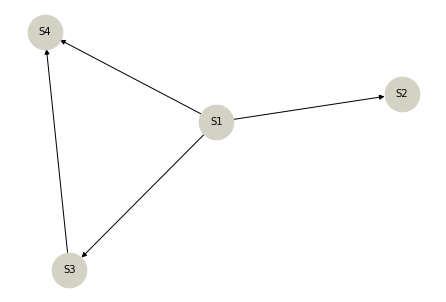

## Initial Setup

In [ ]:
import os
import math
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout
from keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Balancing Strategy

### Stabilized Weights for IPTW

Calculating Stabilized Weights using GMMs for PDF calculation

Src: Equation 2 in Huffman, Curtis, and Edwin van Gameren. "Covariate balancing inverse probability weights for time-varying continuous interventions." Journal of Causal Inference 6.2 (2018): 20170002.

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

#df = pd.read_csv('/.../synthetic_data_continuous_treatment_cov.csv')
df = pd.read_csv('/.../synthetic_data_nonlinear_fixed_cov.csv')
print(df.info())
data = np.array(df)
#data = data[:,2:] #taking only treatment and treatment history

#Normalize the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
print(scaled_data)

n_samples = data.shape[0]
timesteps = 1
input_dim = data.shape[1]

def reshape_time_series_data(data, n_samples, timesteps, input_dim):
    X = data.reshape(int(n_samples / timesteps), timesteps, input_dim)
    return X

time_series_data = reshape_time_series_data(scaled_data, n_samples, timesteps, input_dim)

# Reshape the data to fit GMM
X = time_series_data.reshape(-1, input_dim)

# Choose the number of components for GMM
n_components = 4

# Create and fit the GMM model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(X)

# Predict the component assignments for each data point
component_assignments = gmm.predict(X)

# Reshape the component assignments back to the time-series shape
component_assignments = component_assignments.reshape(n_samples, timesteps)

# Extract means, covariances, and mixing coefficients from the GMM model
means = gmm.means_
covariances = gmm.covariances_
mixing_coeffs = gmm.weights_

sample_data = scaled_data
# Reshape the sample data to fit GMM
sample_data_reshaped = sample_data.reshape(-1, input_dim)

# Calculate the conditional probabilities of each sample data point belonging to each Gaussian component
conditional_probs = np.zeros((sample_data_reshaped.shape[0], n_components))
for i in range(n_components):
    conditional_probs[:, i] = mixing_coeffs[i] * multivariate_normal.pdf(sample_data_reshaped, mean=means[i], cov=covariances[i])

# Calculate the overall PDF as the sum of the PDFs of each Gaussian component
pdf = np.sum(conditional_probs, axis=1)

print(pdf.shape, pdf[:10])

np.save("pdf_treatment_given_covariates.npy",pdf)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   S1          99999 non-null  float64
 1   S2          99999 non-null  float64
 2   S3_history  99999 non-null  float64
 3   S3          99999 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
None
[[0.66700353 0.46307167 0.6065671  0.67870861]
 [0.7240068  0.54157952 0.67870861 0.39894537]
 [0.67126028 0.67889324 0.39894537 0.30270575]
 ...
 [0.18714163 0.37851459 0.35058466 0.55042594]
 [0.15563938 0.41771506 0.55042594 0.57655155]
 [0.12354858 0.49749625 0.57655155 0.42114437]]
(99999,) [11.48948117 20.05058349  4.82739877  4.57484352 16.41667346  5.09631255
  9.50649269 20.02859195 20.53704518 28.48460683]


In [ ]:
pdf_treatment = np.load("/content/pdf_treatment_given_history.npy")
pdf_treatment_cov = np.load("/content/pdf_treatment_given_covariates.npy")
sw = pdf_treatment / pdf_treatment_cov
print(sw.shape, sw[:10])

(99999,) [0.27832515 0.12888201 0.3327099  0.33447589 0.20234836 0.5180543
 0.56630819 0.3686502  0.21681792 0.22492662]


## Loading Combined Data





In [ ]:
#df1 = pd.read_csv('/content/synthetic_data_nonlinear_continuous.csv')
df1 = pd.read_csv('/content/synthetic_data_nonlinear_fixed.csv')
print(df1.info())
data = np.array(df1)
#cf1 -> S4 = 1.1 x S3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   S1      100000 non-null  float64
 1   S2      100000 non-null  float64
 2   S3      100000 non-null  float64
 3   S4      100000 non-null  float64
 4   S4_cf1  100000 non-null  float64
 5   S4_cf0  100000 non-null  float64
dtypes: float64(6)
memory usage: 4.6 MB
None


In [ ]:
target = data[:,3]
cf = data[:,-2:] #factual and counterfactual data
data = data[:,:4]
print(data.shape)
print(cf.shape)
print(target.shape)

(99999, 4)
(99999, 2)
(99999,)


In [ ]:
#Adding a lag to targets
lag = 1
data = data[:-lag,:]
target = target[lag:]

print(data.shape)
print(target.shape)

(99999, 4)
(99999,)


In [ ]:
## Shifting treatment to last column
s3 = data[:,-2].copy()
s3 = s3.reshape(-1,1)
print(s3.shape)
print(data.shape)
data = np.delete(data, -2, 1)
print(data.shape)
data = np.concatenate([data, s3], 1)
print(data.shape)

(99999, 1)
(99999, 4)
(99999, 3)
(99999, 4)


## Train Validation Split

LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features]. We load the csv file and only retain the feature and target columns. The features and target are stored in separate np arrays.

In [ ]:
# Sequential split train:val data in 80:20 sequentially

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = int(LEN_DATA * 0.7)

x_test = data[NUM_TRAIN:]

#split features and labels
y_train=target #[:NUM_TRAIN] target is last column
y_test=target[NUM_TRAIN:] #target is last column

## Creating Treated and Untreated versions of Test Data
Run either fixed treatment or continuous treatment cell for that specific scenario

### Fixed Treatment

In [ ]:
treatment = x_test.copy()
treatment = np.delete(treatment, -1, 1)
print(treatment.shape)

ones=np.expand_dims(np.ones(x_test.shape[0]),1)
zeros=np.expand_dims(np.zeros(x_test.shape[0]),1)

x_untreated = np.concatenate([treatment, zeros], 1)
x_treated = np.concatenate([treatment, ones], 1)

(30000, 3)


### Continuous Treatment

In [ ]:
x_treated = x_test.copy()
x_untreated = x_test.copy()
x_treated[:,-1] = x_treated[:,-1] * 1.1

In [ ]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)
print('x_treated.shape:',x_treated.shape)
print('x_untreated.shape:',x_untreated.shape)

x_train.shape: (99999, 4)
y_train.shape: (99999,)
x_test.shape: (30000, 4)
y_test.shape: (30000,)
x_treated.shape: (30000, 4)
x_untreated.shape: (30000, 4)


## Reshaping Input and Target Features

In [ ]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

## Normalization


In [ ]:
# normalize the features
features = 4
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,features)) #reshaping to 2d for standard scaling
x_test = scaler_f.transform(x_test.reshape(-1,features)) #reshaping to 2d for standard scaling
x_treated = scaler_f.transform(x_treated.reshape(-1,features)) #reshaping to 2d for standard scaling
x_untreated = scaler_f.transform(x_untreated.reshape(-1,features)) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_test = scaler_l.transform(y_test.reshape(-1,1)) #reshaping to 2d for standard scaling


In [ ]:
#Reshaping data to 3D for modeling
timesteps = 1
x_train = reshape_features(x_train, timesteps) # reshaping to 3d for model
x_test = reshape_features(x_test, timesteps) # reshaping to 3d for model

x_treated = reshape_features(x_treated, timesteps) # reshaping to 3d for model
x_untreated = reshape_features(x_untreated, timesteps) # reshaping to 3d for model
#test_data = reshape_features(test_data, timesteps) # reshaping to 3d for model

(99999, 4)
(30000, 4)
(30000, 4)
(30000, 4)


## Specifying the loss function

In [ ]:
# We will use the MSE loss function as base loss
loss_fn = tf.keras.losses.MeanSquaredError() #specify the loss

## Building Model

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.losses import Loss
#from attention import Attention

def model(timestep, features, reg_l2):

    x = Input(shape=(timestep,features), name='input')

    # representation
    phi = LSTM(64, return_sequences=True,name='phi_1')(x)
    phi = Dropout(0.2)(phi)
    phi = LSTM(32, return_sequences=True,name='phi_2')(phi)
    phi = LSTM(32, return_sequences=False,name='phi_3')(phi)
    phi = Dense(units=32, activation='elu', kernel_initializer='RandomNormal',name='phi_4')(phi)
    phi = Dropout(0.2)(phi)

    y0_hidden = Dense(units=16, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_1')(phi)
    y0_hidden = Dense(units=8, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_2')(y0_hidden)
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(y0_hidden)
    model = Model(inputs=x, outputs=y0_predictions)

    return model

In [ ]:
model=model(1,4, .01)
print(model.summary())

## Compiling the Network and Fitting Model

In [ ]:
from tensorflow.keras.optimizers import SGD

val_split=0.2
batch_size=64
verbose=1
i = 0
tf.random.set_seed(i)
np.random.seed(i)

#optimzier hyperparameters
sgd_lr = 1e-5
momentum = 0.9

#Compiling the network
model.compile(loss=loss_fn,
              weighted_metrics = [loss_fn],
              optimizer='adam',sample_weight_mode = 'temporal')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

model.fit(x=x_train,y=y_train,
                validation_split=0.2,
                epochs=20,
                batch_size=batch_size,
                shuffle=True,
                sample_weight=sw,
                callbacks=keras_callbacks,
                verbose=verbose)

## Causal Effect Estimation

In [ ]:
#Replace S3 with ones for Y(1)
import pandas as pd
import numpy as np

y_pred = model.predict(x_test)
y0_pred=model.predict(x_untreated)
y1_pred=model.predict(x_treated)

In [ ]:
#RMSE Model
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = scaler_l.inverse_transform(y_pred)
y_test = scaler_l.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

In [ ]:
#RMSE Treated
y1_pred = scaler_l.inverse_transform(y1_pred)

rmse = sqrt(mean_squared_error(cf[-30000:,0], y1_pred))
print('Treated RMSE: %.3f' % rmse)

In [ ]:
cate_pred=(y1_pred-y0_pred).squeeze()
cate_true=(cf[-30000:,0]-cf[-30000:,1]).squeeze()

In [ ]:
np.save("ite_true_without_balance.npy",cate_true)
np.save("ite_pred_without_balance.npy",cate_pred)

In [ ]:
cate_true = np.load("ite_true.npy")
cate_pred = np.load("ite_pred_without_balance.npy")

In [ ]:
ate_pred=tf.reduce_mean(cate_pred)
ate_true=tf.reduce_mean(cate_true)

print("True ATE:",ate_true.numpy())
print("Estimated ATE:",ate_pred.numpy())

True ATE: 0.9160025658678256
Estimated ATE: -0.50858873


In [ ]:
#PEHE
pehe=tf.reduce_mean( tf.square( ( cate_true - cate_pred) ) )
sqrt_pehe=tf.sqrt(pehe).numpy()
print("\nSQRT PEHE:",sqrt_pehe)


SQRT PEHE: 2.032303148005592


## Uncertainty Estimation

In [ ]:
# Load libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats as st


def uncertainty_estimation(model, title,
                     x_train=x_train, y_train=y_train,
                     x_test1=x_treated1, x_test2=x_treated2,
                     T=50,sampleProportion = 0.9, fileName = 'test', xLabel = 'Expectation', yLabel = 'S4'):
    iterations = T

    # number of samples
    noSamples = int(sampleProportion * len(x_train))
    noSamples2 = int(sampleProportion * len(x_treated1))

    placebo_stats = list()
    #treatment_stats = list()

    for i in range(iterations):
        # Sample data for one bootstrap iteration
        ind = np.random.choice(np.arange(len(x_train)), noSamples)
        sampledData_x = x_train[ind]
        sampledData_y = y_train[ind]
        sampledData_treat = x_treated1[np.random.choice(np.arange(len(x_treated1)), noSamples)]
        # data


        placeboEstimate = np.mean(model.predict(sampledData_x))
        treatmentEstimate = np.mean(model.predict(sampledData_treat))

        placebo_stats.append(placeboEstimate)
        treatment_stats.append(treatmentEstimate)

        stats = pd.DataFrame(
        {'SIE_obs': placebo_stats,
         'SIE_treat': treatment_stats
        })
    sns.set_context("paper")
    sns.set(style="ticks")
    ax = sns.violinplot(data=stats, palette=['r','g'])
    ax.set(xlabel = xLabel, ylabel = yLabel)
    sns.despine()
    figure = ax.get_figure()
    figure.savefig(fileName + ".png", dpi=600)
    alpha = 0.95
    print('Pred under Observed:')
    print('Mean: ' + str(np.mean(placebo_stats)) + ' and Std dev: ' + str(np.std(placebo_stats)))
    print("Confidence Interval:", st.t.interval(alpha, len(placebo_stats)-1, loc=np.mean(placebo_stats), scale=st.sem(placebo_stats)))
    print('Pred under Treatment:')
    print('Mean: ' + str(np.mean(treatment_stats)) + ' and Std dev: ' + str(np.std(treatment_stats)))
    print("Confidence Interval:", st.t.interval(alpha, len(treatment_stats)-1, loc=np.mean(treatment_stats), scale=st.sem(treatment_stats)))



In [ ]:
uncertainty_estimation(model, title='Model')